In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Iteration4').getOrCreate()
from pyspark.sql.functions import to_date
from pyspark.sql.functions import year
from sklearn.utils import resample
import pandas

In [2]:
df1 = spark.read.csv('./NYPD_Arrest_Data__Year_to_Date_.csv', header = True, inferSchema = True)
df2 = spark.read.csv('./NYPD_Arrests_Data__Historic_.csv', header = True, inferSchema = True)

In [3]:
df1 = df1['ARREST_KEY','ARREST_DATE','PD_CD','PD_DESC','KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE', 'AGE_GROUP','PERP_SEX','PERP_RACE','X_COORD_CD','Y_COORD_CD','Latitude','Longitude']
df2 = df2['ARREST_KEY','ARREST_DATE','PD_CD','PD_DESC','KY_CD', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT', 'JURISDICTION_CODE', 'AGE_GROUP','PERP_SEX','PERP_RACE','X_COORD_CD','Y_COORD_CD','Latitude','Longitude']
data = df1.union(df2)
data.toPandas().to_csv('y2d.csv')

In [7]:
expr1 = "^((0[1])[- /.](0[1-9]|[12][0-9]|3[01])[- /.](2021))$"
expr2 = "^(0[7-9]|(1[012])[- /.](0[1-9]|[12][0-9]|3[01])[- /.](2020))$"
df1 = df1.filter(df1['ARREST_DATE'].rlike(expr1))
df2 = df2.filter(df2['ARREST_DATE'].rlike(expr2))

In [8]:
df1 = df1[ ["ARREST_DATE","ARREST_BORO","OFNS_DESC", "ARREST_PRECINCT", "X_COORD_CD", "Y_COORD_CD", "Latitude", "Longitude"] ]
df2 = df2[ ["ARREST_DATE","ARREST_BORO","OFNS_DESC", "ARREST_PRECINCT", "X_COORD_CD", "Y_COORD_CD", "Latitude", "Longitude"] ]

([<matplotlib.axis.XTick at 0x7fbe988d7b70>,
 <a list of 5 Text xticklabel objects>)

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


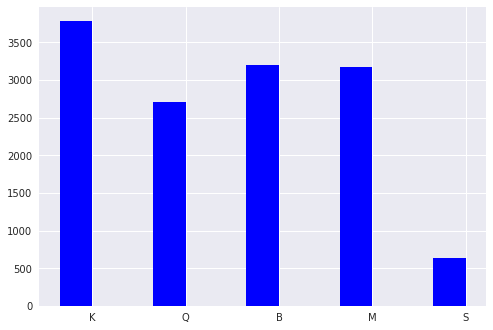

In [38]:
data = df1.union(df2)
data.toPandas().to_csv('y2d.csv')
res = data.groupBy('ARREST_BORO').count().collect()
cat = [i[0] for i in res]
count = [i[1] for i in res]
ind = np.array(range(len(cat)))
width = 0.35
plt.bar(ind,count,width = width,color='b')
plt.xticks(ind+width/2,cat)

In [10]:
data = data.na.drop()

In [11]:
data = data.withColumn("Borough_name", data['ARREST_PRECINCT'])
data = data.replace('B','Bronx', subset = ['Borough_name'])
data = data.replace('M','Manhattan', subset = ['Borough_name'])
data = data.replace('K','Brooklyn', subset = ['Borough_name'])
data = data.replace('S','Staten Island', subset = ['Borough_name'])
data = data.replace('Q','Queens', subset = ['Borough_name'])

In [12]:
pdata = data.toPandas()

In [13]:
cor1=pdata.corr('pearson')
##cor1

In [14]:
cor2=pdata.corr('spearman')

In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
#print('Before Balanced:\n',pdata['ARREST_BORO'].value_counts())
maj = pdata[(pdata.ARREST_BORO== "M")| (pdata.ARREST_BORO== "K")|(pdata.ARREST_BORO== "B")|(pdata.ARREST_BORO== "Q")]
min = pdata[pdata.ARREST_BORO=="S"]
df_majority_downsampled = resample(maj,replace=False, n_samples=2600,random_state=1000) 
df = pandas.concat([df_majority_downsampled, min])
df.ARREST_BORO.value_counts()


K    754
S    638
B    635
M    622
Q    589
Name: ARREST_BORO, dtype: int64

In [43]:
df.to_csv("./training.csv", index=False)

AttributeError: 'DataFrame' object has no attribute 'to_csv'

([<matplotlib.axis.XTick at 0x7fbe9824ccf8>,
 <a list of 5 Text xticklabel objects>)

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


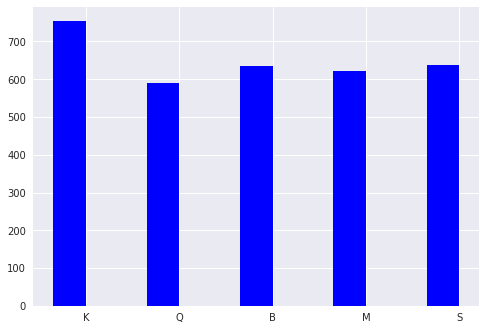

In [40]:
res = df.groupBy('ARREST_BORO').count().collect()
cat = [i[0] for i in res]
count = [i[1] for i in res]
ind = np.array(range(len(cat)))
width = 0.35
plt.bar(ind,count,width = width,color='b')
plt.xticks(ind+width/2,cat)

In [18]:
df = spark.createDataFrame(df)

In [50]:
df.toPandas().to_csv("./historic.csv", index=False)

In [19]:
#df.groupBy('OFNS_DESC').count().show(100, False)

In [20]:
df_backup = df
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

assembler = VectorAssembler(inputCols=['ARREST_PRECINCT', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude'], outputCol='features')
output = assembler.transform(df)
indexer = StringIndexer(inputCol="ARREST_BORO", outputCol="ARREST_BOROind")
output_fixed = indexer.fit(output).transform(output)
final_data = output_fixed.select("features",'ARREST_BOROind')
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [48]:
print(train_data.count())
output_fixed.

2281
+-----------+-----------+--------------------+---------------+----------+----------+------------------+------------------+------------+--------------------+--------------+
|ARREST_DATE|ARREST_BORO|           OFNS_DESC|ARREST_PRECINCT|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|Borough_name|            features|ARREST_BOROind|
+-----------+-----------+--------------------+---------------+----------+----------+------------------+------------------+------------+--------------------+--------------+
| 01/25/2021|          M|OFFENSES INVOLVIN...|             32| 1000977.0|  238383.0|40.820974294000045|-73.93956664899997|          32|[32.0,1000977.0,2...|           3.0|
| 01/10/2021|          Q|     DANGEROUS DRUGS|            101| 1052603.0|  159210.0|40.603415582000025|-73.75384586599995|         101|[101.0,1052603.0,...|           4.0|
| 01/02/2021|          B|MISCELLANEOUS PEN...|             45| 1032140.0|  242004.0| 40.83079891400007|-73.82694879599995|          45|

In [22]:
#Configuring decision tree
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(labelCol='ARREST_BOROind',featuresCol='features',maxDepth=4)
dtmodel = dtc.fit(train_data)
predictions = dtmodel.transform(test_data)

In [29]:
predictions.show()

+--------------------+--------------+--------------------+--------------------+----------+
|            features|ARREST_BOROind|       rawPrediction|         probability|prediction|
+--------------------+--------------+--------------------+--------------------+----------+
|[1.0,981170.0,197...|           3.0|[0.0,0.0,0.0,429....|[0.0,0.0,0.0,1.0,...|       3.0|
|[1.0,981397.0,201...|           3.0|[0.0,0.0,0.0,429....|[0.0,0.0,0.0,1.0,...|       3.0|
|[1.0,982060.0,201...|           3.0|[0.0,0.0,0.0,429....|[0.0,0.0,0.0,1.0,...|       3.0|
|[1.0,982351.0,201...|           3.0|[0.0,0.0,0.0,429....|[0.0,0.0,0.0,1.0,...|       3.0|
|[1.0,982351.0,201...|           3.0|[0.0,0.0,0.0,429....|[0.0,0.0,0.0,1.0,...|       3.0|
|[1.0,982351.0,201...|           3.0|[0.0,0.0,0.0,429....|[0.0,0.0,0.0,1.0,...|       3.0|
|[1.0,983628.0,201...|           3.0|[0.0,0.0,0.0,429....|[0.0,0.0,0.0,1.0,...|       3.0|
|[5.0,983125.0,199...|           3.0|[0.0,0.0,0.0,429....|[0.0,0.0,0.0,1.0,...|       3.0|

In [35]:
from pyspark.ml.classification import RandomForestClassifier
#random forest classifier
rfc = RandomForestClassifier(labelCol='ARREST_BOROind',featuresCol='features', maxDepth = 4, maxBins = 26)
#traing the data
rf_model = rfc.fit(train_data)
#predict data
rf_predictions = rf_model.transform(test_data)
#evaluate
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator(labelCol='ARREST_BOROind', rawPredictionCol='prediction')
print("RF Accuracy: ", eval.evaluate(rf_predictions))

RF Accuracy:  0.9959700226244345


In [36]:
rf_predictions.show()

+--------------------+--------------+--------------------+--------------------+----------+
|            features|ARREST_BOROind|       rawPrediction|         probability|prediction|
+--------------------+--------------+--------------------+--------------------+----------+
|[1.0,981170.0,197...|           3.0|[0.03044735240413...|[0.00152236762020...|       3.0|
|[1.0,981397.0,201...|           3.0|[0.03044735240413...|[0.00152236762020...|       3.0|
|[1.0,982060.0,201...|           3.0|[0.03044735240413...|[0.00152236762020...|       3.0|
|[1.0,982351.0,201...|           3.0|[0.03044735240413...|[0.00152236762020...|       3.0|
|[1.0,982351.0,201...|           3.0|[0.03044735240413...|[0.00152236762020...|       3.0|
|[1.0,982351.0,201...|           3.0|[0.03044735240413...|[0.00152236762020...|       3.0|
|[1.0,983628.0,201...|           3.0|[0.03044735240413...|[0.00152236762020...|       3.0|
|[5.0,983125.0,199...|           3.0|[0.03044735240413...|[0.00152236762020...|       3.0|

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval1 = BinaryClassificationEvaluator(labelCol='ARREST_BOROind', rawPredictionCol='prediction')
print("DT Accuracy: ", eval1.evaluate(predictions))

([<matplotlib.axis.XTick at 0x7fbe9a781d68>,
 <a list of 5 Text xticklabel objects>)

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


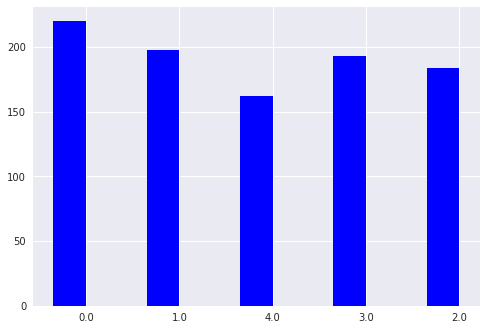

In [37]:
res = rf_predictions.groupBy('prediction').count().collect()
cat = [i[0] for i in res]
count = [i[1] for i in res]
ind = np.array(range(len(cat)))
width = 0.35
plt.bar(ind,count,width = width,color='b')
plt.xticks(ind+width/2,cat)

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


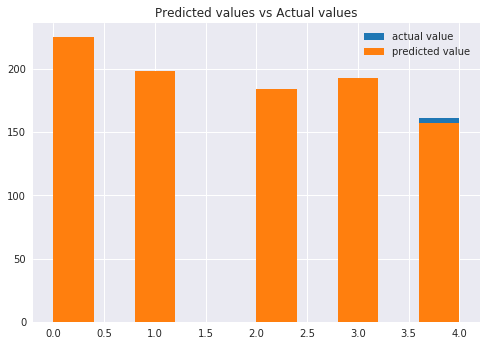

In [45]:
predictionArray = np.array(predictions.select('prediction').collect())
geographicAreaArray = np.array(predictions.select('ARREST_BOROind').collect())
plt.hist(geographicAreaArray, label="actual value")
plt.hist(predictionArray, label="predicted value")
plt.title("Predicted values vs Actual values")
plt.legend(loc='upper right')
plt.show()

/home/ubuntu/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


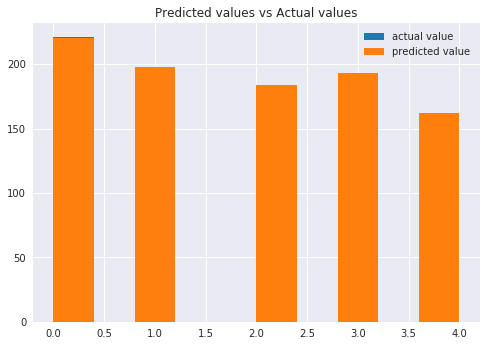

In [46]:
predictionArray = np.array(rf_predictions.select('prediction').collect())
geographicAreaArray = np.array(rf_predictions.select('ARREST_BOROind').collect())
plt.hist(geographicAreaArray, label="actual value")
plt.hist(predictionArray, label="predicted value")
plt.title("Predicted values vs Actual values")
plt.legend(loc='upper right')
plt.show()